In [1]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
import pandas as pd
import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


### 資料處理－雜訊探測

In [2]:
# GazeVector X, Y, Z是判別是否專心的依據，檢查是否有不合理的數值。
# 發現錄製的數據中，不論是＂專心＂、＂不專心＂，皆會出現X, Y, Z皆為0的情況，這些資料無法成為判斷是否專心的依據。
concentrated_df = pd.read_csv('/project/xt121-group5/scene2_data/alice/2023-05-01 232058.csv')
print(concentrated_df.groupby(['GazeVector_X', 'GazeVector_Y', 'GazeVector_Z', 'RecordType'], as_index = True)['GazeVector_X'].count().sort_values(ascending = False))

print('\n==========\n')

concentrated_df = pd.read_csv('/project/xt121-group5/scene2_data/charlie/2023-05-17 103617.csv')
print(concentrated_df.groupby(['GazeVector_X', 'GazeVector_Y', 'GazeVector_Z', 'RecordType'], as_index = True)['GazeVector_X'].count().sort_values(ascending = False))

GazeVector_X  GazeVector_Y  GazeVector_Z  RecordType
 0.000000      0.000000      0.000000     0             311
-0.039100     -0.128691     -0.990914     0               1
-0.093070     -0.391719     -0.915365     0               1
-0.072796     -0.134114     -0.988289     0               1
-0.066171     -0.061354     -0.995920     0               1
                                                       ... 
 0.112946     -0.020573     -0.993388     0               1
 0.113375     -0.021345     -0.993323     0               1
 0.115960     -0.318037     -0.940960     0               1
 0.121167     -0.094276     -0.988145     0               1
-0.721504      0.122935     -0.681409     0               1
Name: GazeVector_X, Length: 110, dtype: int64


GazeVector_X  GazeVector_Y  GazeVector_Z  RecordType
 0.000000      0.000000      0.000000     1             385
 0.460256      0.027177     -0.887370     1               1
-0.142325     -0.082785     -0.986352     1               1
-0.144

## 去除雜訊

In [3]:
# 把發現到會成為雜訊的數據刪除。
def RemoveNoise(dataset, remove_condition):
    # Remove data with gaze vector X, Y, Z have value 0.
    print(f'Total count: {len(dataset)}, gaze vector zero count: {len(dataset[remove_condition])}')

    dataset = dataset.drop(dataset[remove_condition].index)

    print(f'After dropping noises, total count: {len(dataset)}')
    
    return dataset

In [4]:
import os
df_train = pd.core.frame.DataFrame()
for dirname, _, filenames in os.walk('/project/xt121-group5/scene2_data/'):
    for filename in filenames:
        if dirname.split('/')[-1] != 'test_data':
            print(os.path.join(dirname, filename))
            df_train2 = pd.read_csv(os.path.join(dirname, filename))
            df_train2 = RemoveNoise(df_train2, 
                                    (df_train2['GazeVector_X'] == 0) & 
                                    (df_train2['GazeVector_Y'] == 0) & 
                                    (df_train2['GazeVector_Z'] == 0))
            df_train = pd.concat([df_train, df_train2])
        
df_train = df_train.drop(labels = ['RecordTime'], axis = 1) # 移除 RecordTime

/project/xt121-group5/scene2_data/alice/2023-05-01 232058.csv
Total count: 420, gaze vector zero count: 311
After dropping noises, total count: 109
/project/xt121-group5/scene2_data/alice/2023-05-01 231925.csv
Total count: 412, gaze vector zero count: 16
After dropping noises, total count: 396
/project/xt121-group5/scene2_data/pinsian/2023-05-13 142553_c.csv
Total count: 280, gaze vector zero count: 0
After dropping noises, total count: 280
/project/xt121-group5/scene2_data/pinsian/2023-05-13 142611 nc.csv
Total count: 280, gaze vector zero count: 28
After dropping noises, total count: 252
/project/xt121-group5/scene2_data/larry/2023-05-01 232448.csv
Total count: 469, gaze vector zero count: 0
After dropping noises, total count: 469
/project/xt121-group5/scene2_data/larry/2023-05-01 232329.csv
Total count: 305, gaze vector zero count: 0
After dropping noises, total count: 305
/project/xt121-group5/scene2_data/charlie/2023-05-05 103150_c.csv
Total count: 655, gaze vector zero count: 0
A

In [5]:
print(df_train.shape)

(14186, 103)


## 資料前處理

### 前處理－臉部特徵座標平移

In [6]:
# 因為每個人的臉部座標不同，有的人臉部在偏中央位置、有人偏左、偏右，
# 不管臉部位置偏哪，不能成為是否專心的依據，
# 因此一律將所有圖像，臉部座標平移至統一的位置，大家統一，去除掉臉部座標不同的情況。
# 這裡的做法是一律將所有臉部的座標都平移至左上角，即(x, y) = (0, 0)處。
def FaceLandmarksPreprocessing(df_data, verbose = False):
    for col_name in df_data.columns.to_list():
        if col_name.find('FaceLandmarks_') == 0 or \
        col_name.find('EyeLandmarks_') == 0 or \
        col_name.find('LeftEyeBoundingBox_') == 0 or \
        col_name.find('RightEyeBoundingBox_') == 0 or \
        col_name.find('LeftEyeMidPoint_') == 0 or \
        col_name.find('RightEyeMidPoint_') == 0:
            if col_name.find('_X') == len(col_name) - 2:
                df_data[col_name] = df_data[col_name] - df_data['FaceBoundingBox_X']
                if verbose:
                    print(f'Column {col_name} is subtracted by FaceBoundingBox_X.')
            elif col_name.find('_Y') == len(col_name) - 2:
                df_data[col_name] = df_data[col_name] - df_data['FaceBoundingBox_Y']
                if verbose:
                    print(f'Column {col_name} is subtracted by FaceBoundingBox_Y.')
            else:
#                 print(f'Ignore column {col_name}.')
                pass
        else:
#             print(f'Ignore column {col_name}')
            pass
    return df_data

In [7]:
print(df_train.head())

    FaceBoundingBox_X  FaceBoundingBox_Y  FaceBoundingBox_W  \
0                 524                166                253   
1                 525                161                255   
2                 525                163                255   
3                 526                168                255   
15                532                243                205   

    FaceBoundingBox_H  FaceLandmarks_1_X  FaceLandmarks_1_Y  \
0                 253                632                257   
1                 255                634                254   
2                 255                634                256   
3                 255                639                268   
15                205                632                366   

    FaceLandmarks_2_X  FaceLandmarks_2_Y  FaceLandmarks_3_X  \
0                 602                255                679   
1                 603                252                681   
2                 604                255             

In [8]:
df_train = FaceLandmarksPreprocessing(df_train, True)

Column FaceLandmarks_1_X is subtracted by FaceBoundingBox_X.
Column FaceLandmarks_1_Y is subtracted by FaceBoundingBox_Y.
Column FaceLandmarks_2_X is subtracted by FaceBoundingBox_X.
Column FaceLandmarks_2_Y is subtracted by FaceBoundingBox_Y.
Column FaceLandmarks_3_X is subtracted by FaceBoundingBox_X.
Column FaceLandmarks_3_Y is subtracted by FaceBoundingBox_Y.
Column FaceLandmarks_4_X is subtracted by FaceBoundingBox_X.
Column FaceLandmarks_4_Y is subtracted by FaceBoundingBox_Y.
Column FaceLandmarks_5_X is subtracted by FaceBoundingBox_X.
Column FaceLandmarks_5_Y is subtracted by FaceBoundingBox_Y.
Column FaceLandmarks_6_X is subtracted by FaceBoundingBox_X.
Column FaceLandmarks_6_Y is subtracted by FaceBoundingBox_Y.
Column FaceLandmarks_7_X is subtracted by FaceBoundingBox_X.
Column FaceLandmarks_7_Y is subtracted by FaceBoundingBox_Y.
Column FaceLandmarks_8_X is subtracted by FaceBoundingBox_X.
Column FaceLandmarks_8_Y is subtracted by FaceBoundingBox_Y.
Column FaceLandmarks_9_X

In [9]:
# 臉部座標如同前述，不能成為是否專心的依據。
# 在成為臉部許多特徵x, y座標值平移量的依據後，已不再被需要，故從訓練資料中刪除之。
col_deleted = ['FaceBoundingBox_X', 'FaceBoundingBox_Y']
df_train = df_train.drop(col_deleted, axis = 1)

In [10]:
print(df_train.head())

    FaceBoundingBox_W  FaceBoundingBox_H  FaceLandmarks_1_X  \
0                 253                253                108   
1                 255                255                109   
2                 255                255                109   
3                 255                255                113   
15                205                205                100   

    FaceLandmarks_1_Y  FaceLandmarks_2_X  FaceLandmarks_2_Y  \
0                  91                 78                 89   
1                  93                 78                 91   
2                  93                 79                 92   
3                 100                 86                 98   
15                123                 88                128   

    FaceLandmarks_3_X  FaceLandmarks_3_Y  FaceLandmarks_4_X  \
0                 155                 92                184   
1                 156                 93                186   
2                 156                 93             

### 前處理－檢查缺失值

In [11]:
# checked missing data
print("Before data clean(NAN mount):", len(np.where(np.isnan(df_train)==1)[0]))

Before data clean(NAN mount): 0


In [12]:
# 取目標值。
y = df_train['RecordType'].values
print(y.shape)

# 訓練資料刪除目標值。
df_train = df_train.drop('RecordType', axis = 1)

(14186,)


In [13]:
np.unique(y)
print(y)

[0 0 0 ... 1 1 1]


## 切割訓練集

In [14]:
x_train, x_valid, y_train, y_valid = train_test_split(df_train, y, test_size = 0.25, random_state = 17, stratify = y)

## 訓練模型

In [15]:
# eval_metrics can selecy rmse, logloss, error,\
# auc, merror, mlogloss or custom define
eval_set = [(x_valid, y_valid)]
model = XGBClassifier(early_stopping_rounds = 10, 
                      eval_metric = "auc")
print(type(x_train))
print(type(y_train))
model.fit(x_train, 
          y_train, 
          eval_set = eval_set, 
          verbose = True)

<class 'pandas.core.frame.DataFrame'>
<class 'numpy.ndarray'>
[0]	validation_0-auc:0.956423
[1]	validation_0-auc:0.962058
[2]	validation_0-auc:0.967715
[3]	validation_0-auc:0.969399
[4]	validation_0-auc:0.969342
[5]	validation_0-auc:0.970791
[6]	validation_0-auc:0.970891
[7]	validation_0-auc:0.973908
[8]	validation_0-auc:0.976221
[9]	validation_0-auc:0.976634
[10]	validation_0-auc:0.977168
[11]	validation_0-auc:0.978768
[12]	validation_0-auc:0.980768
[13]	validation_0-auc:0.981779
[14]	validation_0-auc:0.981811
[15]	validation_0-auc:0.982051
[16]	validation_0-auc:0.983972
[17]	validation_0-auc:0.984326
[18]	validation_0-auc:0.984563
[19]	validation_0-auc:0.985947
[20]	validation_0-auc:0.986969
[21]	validation_0-auc:0.987223
[22]	validation_0-auc:0.987736
[23]	validation_0-auc:0.987719
[24]	validation_0-auc:0.988014
[25]	validation_0-auc:0.988694
[26]	validation_0-auc:0.988994
[27]	validation_0-auc:0.98965
[28]	validation_0-auc:0.990873
[29]	validation_0-auc:0.991272
[30]	validation_0-a

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, early_stopping_rounds=10,
              eval_metric='auc', gamma=0, learning_rate=0.1, max_delta_step=0,
              max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
              n_jobs=1, nthread=None, objective='binary:logistic',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=None, subsample=1, verbosity=1)

In [16]:
# model.predict_proba will return the probility
# model.predict will return the predict label (use 0.5 as threshold)
y_pred = model.predict_proba(x_valid)
y_pred[:5]

array([[1.8398345e-02, 9.8160166e-01],
       [2.7868152e-03, 9.9721318e-01],
       [9.9949908e-01, 5.0094287e-04],
       [2.8699088e-01, 7.1300912e-01],
       [6.4999223e-02, 9.3500078e-01]], dtype=float32)

In [17]:
# we use model.predict to get the label
y_pred = model.predict(x_valid)
accuracy = accuracy_score(y_valid, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 99.10%


In [18]:
# f1-score
accuracy_f1 = f1_score(y_valid, y_pred)
print("f1-score: %.2f%%" % (accuracy_f1 * 100.0))

f1-score: 99.20%


In [19]:
# we can show the feature importances for our features
print(model.feature_importances_)

[1.7280987e-02 0.0000000e+00 1.6323656e-02 0.0000000e+00 1.1156488e-02
 1.1252221e-02 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 7.2918348e-03 6.9992458e-03 2.4651599e-03 4.9541444e-03 0.0000000e+00
 1.9992136e-03 7.3512560e-03 8.7303817e-03 1.3245014e-02 5.8219652e-05
 6.2801661e-03 0.0000000e+00 2.6169842e-02 0.0000000e+00 6.4332895e-03
 1.0355452e-02 0.0000000e+00 2.9148122e-02 1.0881376e-02 5.2246109e-02
 9.3753552e-03 2.1087073e-02 1.3529698e-02 4.8432201e-03 0.0000000e+00
 0.0000000e+00 9.9114829e-04 6.7690047e-03 2.7319344e-02 3.1827342e-02
 3.0630916e-02 2.1751632e-03 2.1864180e-02 9.9461554e-03 1.1267915e-02
 6.2908269e-03 2.5260535e-03 0.0000000e+00 0.0000000e+00 0.0000000e+00
 1.2945598e-02 7.8188255e-03 1.1913390e-02 3.9193640e-03 1.5174389e-02
 2.1472892e-02 5.1766927e-03 3.0183777e-02 1.1569049e-03 1.2201495e-02
 1.9525267e-03 1.3894730e-02 3.1572087e-03 6.1321788e-04 1.3427305e-03
 1.6060993e-02 1.8064060e-03 0.0000000e+00 1.8895825e-02 0.0000000e+00
 0.000

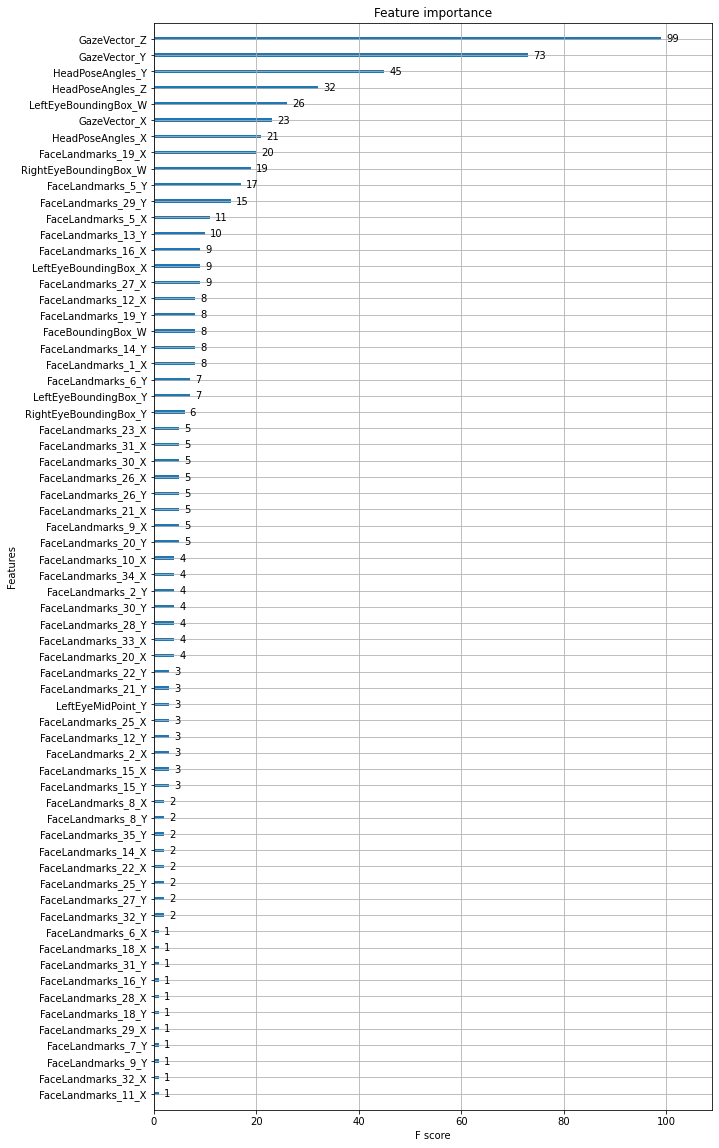

In [20]:
# import the plot_importance function to visualize the feature importance
from xgboost import plot_importance
# plot_importance(model)
# plt.show()

fig, ax = plt.subplots(figsize=(10, 20))
plot_importance(model, ax=ax)
plt.show()

In [21]:
!pip install graphviz

<Figure size 864x864 with 0 Axes>

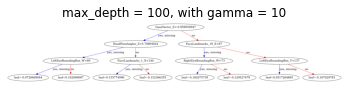

In [22]:
from xgboost import plot_tree
from matplotlib.pylab import rcParams

plt.figure(figsize=(12, 12))
plot_tree(model, num_trees = 1)
plt.title("max_depth = 100, with gamma = 10")
plt.savefig("plot_tree_xgboost_norm_all_features", dpi = 300)